In [1]:
## Scikit learn libraries
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier

## For NLP
from bs4 import BeautifulSoup, Tag    ## Cleaning HTML tags from text
import nltk, string
from nltk.corpus import stopwords 
import re

## Common Python libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Data I/O
import json     ## To convert json raw data to df
import pickle   ## saving the model to disk

import xgboost as xgb
from scipy.stats import uniform, randint

#from keras.preprocessing import text, sequence
#from keras import layers, models, optimizers

## Problem texts can be long and may not load on Jupyter
pd.set_option('display.max_colwidth', -1)    

## Extract subject wise training data

In [2]:
# Load the dataset and show sample question
with open('../data/qs_topicwise.json') as json_data:
    all_questions = json.load(json_data)

subject_model = ['PHY']

## Create empty df 
data_df = pd.DataFrame(columns=['code', 'curriculum', 'subject', 'grade', 'question_text', 'chapter'])

## Removing these words improves Phy clf accuracy by 2% but improves Math classifier accuracy
words_to_remove = ["rightarrow", "hence", "frac", "text", "sqrt", "times", 
                   "value", "amp", "statement", "will", "equal", "number", 
                   "tan", "now", "can", "two", "get", "true", "lambda", "a", "an", "the"]
stop_words = stopwords.words('english')         ## Downloaded from NLTK
'''
Stopwords reduce acc & f1 score for Physics. 67% -> 63%, 74% -> 72%

'''

## Remove dummy and empty chapters
chapters_to_remove = ['Selection Test', 'Repository', 'Bridge Intervention Curriculum', 
                      'M1.1 Scaffold test', 'Tally Marks', 'Dummy']
chapters_with_no_data = ['Static Electricity', 'Experimental Skills', 'Nuclear Chemistry', 
                         'Principle of Mathematical Induction', 'Environmental Chemistry']

## Regex pattern for alpha numeric - Improves accuracy & f1-score for Phy by 2%
pattern = re.compile('[\W_]+')

i = 0
for question in all_questions:
    try: 
        question_text = question['question_text'].lower()
        ## Remove HTML tags from text using Beautiful Soup
        '''
        For MTH, it improves accuracy from 40% to 60% in MTH, 
        For PHY, it reduces accuracy from 60% to 20%. 
        For CHM, it increases accuracy from 50% to 52% 
        '''
        question_text = BeautifulSoup(question_text, "html.parser").get_text() 
        ## Remove numbers
        '''
        For PHY, improved accuracy & F1 score by 0.5%
        '''
        question_text = ''.join(c for c in question_text if not c.isdigit())
        ## Regex pattern for alpha numeric text
        question_text = pattern.sub(" ", question_text)
        ## Remove stop words
        question_text = " ".join([word for word in question_text.split() if word not in words_to_remove])
        #question_text = " ".join([word for word in question_text.split() if word not in stop_words])
        ## Remove extra whitespaces
        question_text = " ".join(question_text.split()) 
        ## Extracting elements for cleaner code
        grade = question['grade']
        curriculum = question['curriculum']
        chapter = question['chapter']
        subject = question['subject']
        ## Filtering each question from JSON to add relevant Qs to dataframe 
        if(    "JEE" in curriculum and grade in ["11", "12"] and
               chapter not in chapters_to_remove and
               chapter not in chapters_with_no_data and
               "dummy" not in question_text and subject in subject_model):
                data_df.loc[i] = [question['problem_code'], curriculum, subject, \
                                  grade, question_text, chapter]
                i += 1
    except:
            pass

trainDF = pd.DataFrame(columns=['text', 'label'])
trainDF['text'] = data_df['question_text']
trainDF['label'] = data_df['chapter']
trainDF.head(3)

,text,label
0,which of following changes increase stopping potential,Modern Physics
1,keeping frequency as well intensity of light source constant if we gradually increase potential of anode giving it positive potential w r t cathode,Modern Physics
2,photons photon photon are travelling in vacuum consider following cases case when photons are travelling in same direction case when photons are travelling in opposite directions speed of photon w r t photon,Modern Physics


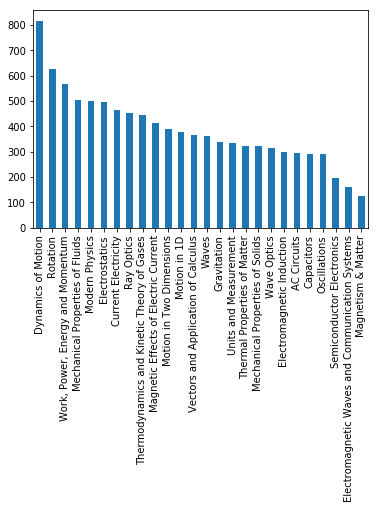

In [3]:
trainDF.label.value_counts().plot(kind="bar")

## Train test split

In [4]:
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(trainDF['text'], trainDF['label'], test_size=0.2)
print(len(train_x), len(valid_x) )

8061 2016


## Create pipeline for vectorizer & classifier

Label encoding is not needed. All sklearn classifiers are capable of mutli-class classification. Source :  https://stackoverflow.com/questions/51525043/encoding-labels-for-multi-class-problems-in-sckit-learn

In [5]:
## Custom Tokenizer for Vectorizer (no default by sklearn)
'''
Improves accuracy & f1 score for PHY by 2%
'''
stemmer = nltk.stem.porter.PorterStemmer()    ## May need to download this with "nltk.download('punkt')"
remove_punctuation_map = dict((ord(char), None) for char in string.punctuation)
def stem_tokens(tokens):
    return [stemmer.stem(item) for item in tokens]
def normalize(text):
    return stem_tokens(nltk.word_tokenize(text.translate(remove_punctuation_map)))

## Initializing vectorizer
vec = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3),
                      lowercase=True, tokenizer=normalize, max_features=10000, 
                      use_idf = True, min_df = 5, max_df = 0.8, stop_words = None)
## Can't add stop words here as the text is normalized and it won't match the stop words list. Should remove earlier.
## https://stackoverflow.com/questions/57340142/user-warning-your-stop-words-may-be-inconsistent-with-your-preprocessing

## Initializaing classifier
#clf = naive_bayes.MultinomialNB()                                                        ## Accuracy 60%
clf = linear_model.LogisticRegression(multi_class='multinomial', solver='newton-cg', C=7.5)     ## Accuracy 75.9%
#clf = xgb.XGBClassifier(objective="multi:softprob", random_state=42)           ## Hyper-param opt too slow, worse than base
#clf = RandomForestClassifier(n_estimators=120, max_depth=7, min_samples_leaf=10,          ## Base accuracy 27%
#                             max_features=0.7, n_jobs=-1, oob_score=True)      ## Too slow with 100+ trees
#clf = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-2,                               ## Accuracy 73.4%
#                    random_state=42, max_iter=4, tol=None)


## Setting up pipeline
pipe = make_pipeline(vec, clf)
pipe.fit(train_x, train_y)

Pipeline(memory=None,
     steps=[('tfidfvectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.8, max_features=10000, min_df=5,
        ngram_range=(2, 3), norm='l2', preprocessor=None, smoot...ty='l2', random_state=None, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False))])

## Prediction & Evaluation metrics

In [6]:
pred_y = pipe.predict(valid_x)
report = metrics.classification_report(valid_y, pred_y)
print(report)
print("accuracy: {:0.3f}".format(metrics.accuracy_score(valid_y, pred_y)))
print("F1-score (weighted): {:0.3f}".format(metrics.f1_score(valid_y, pred_y, average = 'weighted')))
## Support is the number of occurrences of each class in valid_y

                                                 precision    recall  f1-score   support

                                    AC Circuits       0.79      0.87      0.83        53
                                     Capacitors       0.80      0.73      0.77        60
                            Current Electricity       0.70      0.79      0.74        94
                             Dynamics of Motion       0.62      0.79      0.70       160
                      Electromagnetic Induction       0.87      0.55      0.67        60
Electromagnetic Waves and Communication Systems       0.67      0.47      0.55        38
                                 Electrostatics       0.83      0.88      0.86       109
                                    Gravitation       0.89      0.76      0.82        78
           Magnetic Effects of Electric Current       0.69      0.88      0.77        68
                             Magnetism & Matter       0.90      0.30      0.45        30
                Mech

This is a higher accuracy than the baseline Naive Bayes model made earlier !
It can be attributed to the Logistic Regression model, along with custom tokenizer better hyper parameters

### Confusion Matrix

In [7]:
metrics.confusion_matrix(valid_y, pred_y)

array([[ 46,   0,   4,   2,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   1,   0,   0,   0,   0,   0,   0,   0],
       [  1,  44,   4,   2,   0,   0,   7,   0,   0,   0,   1,   0,   1,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  2,   5,  74,   1,   1,   0,   0,   0,   1,   0,   1,   0,   1,
          1,   1,   0,   0,   0,   1,   3,   1,   0,   0,   0,   0,   1],
       [  0,   0,   0, 127,   0,   0,   2,   0,   0,   0,   1,   0,   1,
          5,   4,   1,   0,   3,   0,   0,   0,   1,   4,   0,   0,  11],
       [  6,   0,   5,   1,  33,   0,   3,   0,   9,   0,   0,   0,   0,
          0,   0,   1,   0,   1,   1,   0,   0,   0,   0,   0,   0,   0],
       [  0,   1,   3,   2,   0,  18,   1,   1,   1,   0,   1,   0,   2,
          1,   0,   1,   2,   0,   1,   0,   0,   1,   1,   0,   1,   0],
       [  0,   4,   0,   1,   0,   0,  96,   1,   2,   0,   1,   0,   1,
          0,   0,   0,   0,   0,   0,   0,   

### Hyper-parameter optimization 
#### xgb hyper-params (don't run locally)

In [8]:
'''
## This will consume 100% CPU, run on Kaggle / server
def report_best_scores(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
            
xgb_model = xgb.XGBClassifier(objective="multi:softprob", random_state=42)

vec.fit(trainDF['text'])
xtrain_tfidf_ngram =  vec.transform(train_x)

params = {
    "colsample_bytree": uniform(0.7, 0.3),
    "gamma": uniform(0, 0.5),
    "learning_rate": uniform(0.03, 0.3), # default 0.1 
    "max_depth": randint(2, 6), # default 3
    "n_estimators": randint(100, 150), # default 100
    "subsample": uniform(0.6, 0.4)
}

search = model_selection.RandomizedSearchCV(xgb_model, param_distributions=params, random_state=42, n_iter=200,
                            cv=3, verbose=1, n_jobs=1, return_train_score=True)

#search.fit(train_x[:,np.newaxis], train_y)
search.fit(xtrain_tfidf_ngram, train_y)

report_best_scores(search.cv_results_, 1)
'''

'\n## This will consume 100% CPU, run on Kaggle / server\ndef report_best_scores(results, n_top=3):\n    for i in range(1, n_top + 1):\n        candidates = np.flatnonzero(results[\'rank_test_score\'] == i)\n        for candidate in candidates:\n            print("Model with rank: {0}".format(i))\n            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(\n                  results[\'mean_test_score\'][candidate],\n                  results[\'std_test_score\'][candidate]))\n            print("Parameters: {0}".format(results[\'params\'][candidate]))\n            print("")\n            \nxgb_model = xgb.XGBClassifier(objective="multi:softprob", random_state=42)\n\nvec.fit(trainDF[\'text\'])\nxtrain_tfidf_ngram =  vec.transform(train_x)\n\nparams = {\n    "colsample_bytree": uniform(0.7, 0.3),\n    "gamma": uniform(0, 0.5),\n    "learning_rate": uniform(0.03, 0.3), # default 0.1 \n    "max_depth": randint(2, 6), # default 3\n    "n_estimators": randint(100, 150), # default 

#### SVM Hyper-params
Source : https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html

#### Chapters that were never predicted

In [9]:
set(valid_y) - set(pred_y)

set()

### Check + and - weights of the model, and which feature contribute to prediction
Manually

In [10]:
'''
for i, tag in enumerate(clf.classes_):
    coefficients = clf.coef_[i]
    weights = list(zip(vec.get_feature_names(),coefficients))
    print('Tag:',tag)
    print('Most Positive Coefficients:')
    print(sorted(weights,key=lambda x: -x[1])[:10])
    print('Most Negative Coefficients:')
    print(sorted(weights,key=lambda x: x[1])[:10])
    print("--------------------------------------")
'''

'\nfor i, tag in enumerate(clf.classes_):\n    coefficients = clf.coef_[i]\n    weights = list(zip(vec.get_feature_names(),coefficients))\n    print(\'Tag:\',tag)\n    print(\'Most Positive Coefficients:\')\n    print(sorted(weights,key=lambda x: -x[1])[:10])\n    print(\'Most Negative Coefficients:\')\n    print(sorted(weights,key=lambda x: x[1])[:10])\n    print("--------------------------------------")\n'

#### +ve and -ve Weights using eli5

In [11]:
import eli5
eli5.show_weights(clf, vec=vec, top=50)

## Misclassified Examples

In [12]:
valid = pd.concat([valid_x, valid_y], axis=1)
valid['pred'] = pred_y
valid.head(10)

,text,label,pred
3465,in l r growth circuit inductance and resistance used are henry and omega respectively if at t ms current in circuit is then applied direct current emf is,Electromagnetic Induction,AC Circuits
2420,phenomenon of diffraction is more noticeable for sound waves than for light waves because sound waves,Wave Optics,Waves
5280,insect crawls up hemispherical surface very slowly see fig coefficient of friction between insect and surface is if line joining centre of hemispherical surface to insect makes angle alpha with vertical find maximum possible of alpha,Dynamics of Motion,Dynamics of Motion
1350,point charge q is placed at corner of square of side find flux through square,Electrostatics,Electrostatics
3190,motor in normal operation carries direct current of when connected to v power supply resistance of motor windings is omega while in normal operation at what rate is internal energy produced in windings,Electromagnetic Induction,Electromagnetic Induction
506,in any material free moving electrons keep colliding with holes this process of recombination leads to removal of charge carriers simultaneously does this process affect charge carrier density in material if yes how,Semiconductor Electronics,Electrostatics
5781,projectile is fired with speed of m s at angle of circ find its speed when its direction of motion makes angle circ with horizontal,Motion in Two Dimensions,Motion in Two Dimensions
4917,friction coefficient between table and block shown in figure is find tensions in strings,Dynamics of Motion,Dynamics of Motion
10066,resultant of and b is r on reversing vector b resultant becomes r what is of r r,Vectors and Application of Calculus,Vectors and Application of Calculus
2137,sources are placed on x axis at separation d observer starts moving from on circular track of radius r r d angular positions of minima diagram,Wave Optics,Wave Optics


In [13]:
misclassified_examples = valid[valid.label != valid.pred]
misclassified_examples.head()

,text,label,pred
3465,in l r growth circuit inductance and resistance used are henry and omega respectively if at t ms current in circuit is then applied direct current emf is,Electromagnetic Induction,AC Circuits
2420,phenomenon of diffraction is more noticeable for sound waves than for light waves because sound waves,Wave Optics,Waves
506,in any material free moving electrons keep colliding with holes this process of recombination leads to removal of charge carriers simultaneously does this process affect charge carrier density in material if yes how,Semiconductor Electronics,Electrostatics
7835,pressure that has to be applied to ends of steel wire of length cm to keep its length constant when its temperature is raised by circ c is for steel young s modulus is n m and coefficient of thermal expansion is k,Thermal Properties of Matter,Mechanical Properties of Solids
7504,wind above roof blows with speed of m s parallel to roof of house area of roof is m assuming that pressure inside house is atmospheric pressure net force exerted by air on roof and direction of force be left rho air kg m right,Mechanical Properties of Fluids,Dynamics of Motion


#### Checking 2nd row

In [14]:
eli5.show_prediction(clf, misclassified_examples['text'].values[1], vec=vec)

### Serialize trained model to disk

In [15]:
## Encoder not needed for sklearn models
## Vectorizer
with open('vec_phy.pkl', 'wb') as f:
    pickle.dump(vec, f, pickle.HIGHEST_PROTOCOL)
## Classifer
with open('clf_phy.pkl', 'wb') as f:
    pickle.dump(clf, f, pickle.HIGHEST_PROTOCOL)
## Repo for similar questions
with open('repo_phy.pkl', 'wb') as f:
    pickle.dump(data_df, f, pickle.HIGHEST_PROTOCOL)